## 1D Be lens with $R=100\mu$m - experimental data

created: **31/08/2022**; last edited: **31/08/2022**

[rafael.celestre@esrf.eu](mailto:rafael.celestre@esrf.eu)

<hr style="border:1px solid gray">

In [1]:
# imports

# checking we are using the correct python:
import sys
print(sys.executable)
print(sys.version)
sys.path.insert(0, '../../pylibs/')

%matplotlib notebook
import matplotlib.pylab as pl

import utils as uti

import barc4plots.barc4plots as b4pt         # get barc4plots: https://gitlab.esrf.fr/celestre/barc4plots

import fabio as io
from glob import glob
import numpy as np

/home/esrf/celestre/miniconda/envs/xog/bin/python
3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]


In [2]:
# files to be trated & global variables

pix_size = 1.577  # in um
scan = [5, 10, 15]     # angles for the scan (degrees)
dpi = 250   # for plots

gradient_list = sorted(glob('./1D_Be_R100um_orthogonal/*grad_h.tif'))

debug = False

#### x-ray lens ideal parameters

In [3]:
# x-ray lens parameters in meters

mat = 'Be'

R = 100e-6   # radius
L = 1e-3    # total thickness
wt = 35e-6  # wall thickness
Av = 2*np.sqrt((L-wt)*R)  # geometric aperture
Ah = 2e-3
focal_plane = 2          # plane of focusing: 1- horizontal, 2- vertical, 3- both
nCRL = 1

half_width = 75

dv = 500
dh = 1500

<hr style="border:1px solid gray">

### Gradients extraction

#### before running this cell, run the interactive script _aux_1D_lens_centering.py_ for having the manually selected center of the lens(es).

In [4]:
# loop for gradient extraction:


k = 0
centre = np.load('./results/1D_Be_R100um_cen_orthogonal.npy')

for grad in gradient_list:
    
    centre_h = int(centre[k, 1])
    centre_v = int(centre[k, 0])

    radio = io.open(grad.replace('grad_h', 'radio')).data

    if k == 0:
        hh = np.zeros([len(gradient_list), radio.shape[1]])       # hor. cuts
        vv = np.zeros([len(gradient_list), radio.shape[0]])       # ver. cuts
        vvbis = np.zeros([len(gradient_list), radio.shape[0]])    # ver. cuts bis
        hhbis = np.zeros([len(gradient_list), radio.shape[1]])    # ver. cuts bis
        x = np.zeros([len(gradient_list), radio.shape[1]])        # hor. axis
        y = np.zeros([len(gradient_list), radio.shape[0]])        # ver. axis

    x[k, :] = (np.linspace(0, radio.shape[1]-1, radio.shape[1]) - centre_h)*pix_size*1e-6  # hor. axis
    y[k, :] = (np.linspace(0, radio.shape[0]-1, radio.shape[0]) - centre_v)*pix_size*1e-6  # ver. axis  

    # vertical gradient
    
    grad_v = io.open(grad.replace('_h', '_v')).data
    data_v = uti.get_averaged_gradient(grad_v, 'v', silent=debug)
    grad_v -= (data_v['points']['lmin']+data_v['points']['rmax'])/2
    centre_v = int((data_v['points']['axr']+data_v['points']['axl'])/2)
    
    grad_v -= np.mean(grad_v[int(centre_v)-half_width:int(centre_v)+half_width, 
                     int(centre_h)-half_width:int(centre_h)+half_width])
    
    vv[k, :] = grad_v[:, centre_h]
    vvbis[k, :] = np.mean(grad_v[:, centre_h-half_width:centre_h+half_width], axis=1)
    if k == len(gradient_list)-1:
        centre_v = int(centre[k, 0])
    y[k, :] = (np.linspace(0, radio.shape[0]-1, radio.shape[0]) - centre_v)*pix_size*1e-6  # ver. axis  
   
    # horizontal gradient
    grad_h = io.open(grad).data
    grad_h -= np.mean(grad_h[int(centre_v)-half_width:int(centre_v)+half_width, 
                             int(centre_h)-half_width:int(centre_h)+half_width])


    hh[k, :] = grad_h[int(centre_v), :]
    vv[k, :] = grad_v[:, int(centre_h)]
    vvbis[k, :] = np.mean(grad_v[:, int(centre_h-half_width):int(centre_h+half_width)], axis=1)
    hhbis[k, :] = np.mean(grad_h[int(centre_v-half_width):int(centre_v+half_width), :], axis=0)

    image = b4pt.Image2Plot(np.transpose(radio), y[k, :] * 1e6, x[k, :] * 1e6)
    image.legends = ['', '($\mu$m)', '($\mu$m)']
    image.Colorbar = False
    image.LaTex = True
    image.AspectRatio = True
    image.ColorScheme = 2
    image.plt_limits = [np.mean(radio)-3*np.std(radio), np.mean(radio)+3*np.std(radio)]
    image.ax_limits = [-dv, dv, -dh, dh]
    image.FontsSizeScale = 1.3
    image.sort_class()
    b4pt.plot_2D(image, './results/1D_Be_R100um_radio_exp_%s_orthogonal.png' % scan[k], Enable=False, Silent=True, dpi=dpi) 

    image = b4pt.Image2Plot(np.transpose(grad_v)*1e6, y[k, :] * 1e6, x[k, :] * 1e6)
    image.legends = ['', '($\mu$m)', '($\mu$m)']
    image.Colorbar = True
    image.LaTex = True
    image.AspectRatio = True
    image.ColorScheme = 12
    image.plt_limits = [-15, 15]
    image.ax_limits = [-dv, dv, -dh, dh]
    image.FontsSizeScale = 1.3
    image.sort_class()
    b4pt.plot_2D_cuts(image, './results/1D_Be_R100um_ver_grad_exp_%s_orthogonal.png'%scan[k], Enable=False, Silent=True, dpi=dpi, x=0, y=0)

    image = b4pt.Image2Plot(np.transpose(grad_h)*1e6, y[k, :] * 1e6, x[k, :] * 1e6)
    image.legends = ['', '($\mu$m)', '($\mu$m)']
    image.Colorbar = True
    image.LaTex = True
    image.AspectRatio = True
    image.ColorScheme = 12
    image.plt_limits = [-15, 15]
    image.ax_limits = [-dv, dv, -dh, dh]
    image.FontsSizeScale = 1.3
    image.sort_class()
    b4pt.plot_2D_cuts(image, './results/1D_Be_R100um_hor_grad_exp_%s_orthogonal.png'%scan[k], Enable=False, Silent=True, dpi=dpi, x=0, y=0)

    k+=1

np.save('./results/1D_Be_R100um_hor_grad_exp_orthogonal', vv)
np.save('./results/1D_Be_R100um_ver_grad_exp_orthogonal', hh)
np.save('./results/1D_Be_R100um_ver_grad_exp_bis_orthogonal', hhbis)     # averaged data

np.save('./results/1D_Be_R100um_hor_grad_axis_exp_orthogonal', y)
np.save('./results/1D_Be_R100um_ver_grad_axis_exp_orthogonal', x)


>>>> file 1D_Be_R100um_radio_exp_5_orthogonal.png saved to disk.
>>>> file 1D_Be_R100um_ver_grad_exp_5_orthogonal.png saved to disk.
>>>> file 1D_Be_R100um_hor_grad_exp_5_orthogonal.png saved to disk.
>>>> file 1D_Be_R100um_radio_exp_10_orthogonal.png saved to disk.
>>>> file 1D_Be_R100um_ver_grad_exp_10_orthogonal.png saved to disk.
>>>> file 1D_Be_R100um_hor_grad_exp_10_orthogonal.png saved to disk.
>>>> file 1D_Be_R100um_radio_exp_15_orthogonal.png saved to disk.
>>>> file 1D_Be_R100um_ver_grad_exp_15_orthogonal.png saved to disk.
>>>> file 1D_Be_R100um_hor_grad_exp_15_orthogonal.png saved to disk.


In [5]:
# plotting vertical gradient cuts

# vv = np.load('./results/1D_Be_R100um_ver_grad_exp.npy')
# vvbis = np.load('./results/1D_Be_R100um_ver_grad_exp_bis.npy')    # averaged data
# y = np.load('./results/2D_Be_R50um_ver_grad_axis_exp.npy')

>>>> file 1D_Be_R100um_ver_grad_exp_cuts_orthogonal.png saved to disk.


<IPython.core.display.Javascript object>


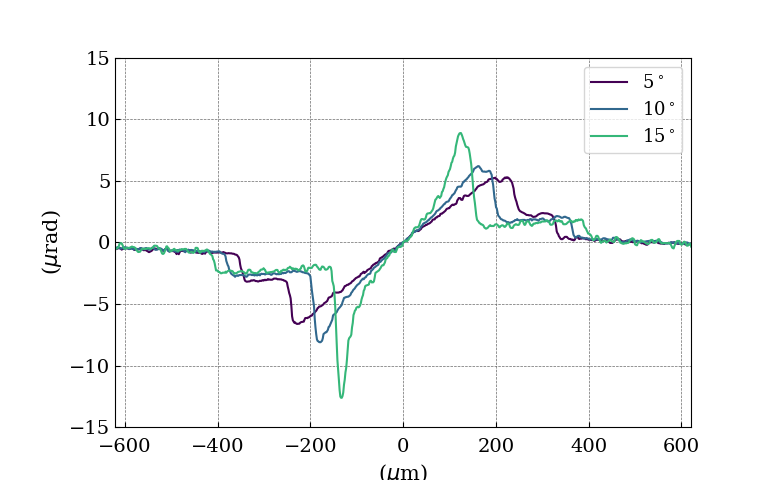

In [6]:
colors = pl.cm.viridis(np.linspace(0,1,len(scan)+1))

for i in range(len(scan)):
    image = b4pt.Image2Plot(hh[i, :]*1e6, x[i, :]*1e6)
    image.AspectRatio = False
    image.LaTex = True
    image.legends = ['', '($\mu$m)', '($\mu$rad)']
    image.LineStyle = '-'
    image.label = str(scan[i])+'$^\circ$'
    image.LabelPos = 1
    image.ax_limits = [-Av*1e6, Av*1e6, -15, 15]
    image.grid = True
    image.sort_class()
    image.ColorScheme =  colors[i]
    if i == 0:
        b4pt.plot_1D(image, Enable=False, Hold=False)
    elif i == len(scan)-1:
        b4pt.plot_1D(image, './results/1D_Be_R100um_ver_grad_exp_cuts_orthogonal.png', Enable=True, Hold=True, dpi=dpi)
    else:
        b4pt.plot_1D(image, Enable=False, Hold=True)

>>>> file 1D_Be_R100um_ver_grad_exp_cuts_bis_orthogonal.png saved to disk.


<IPython.core.display.Javascript object>


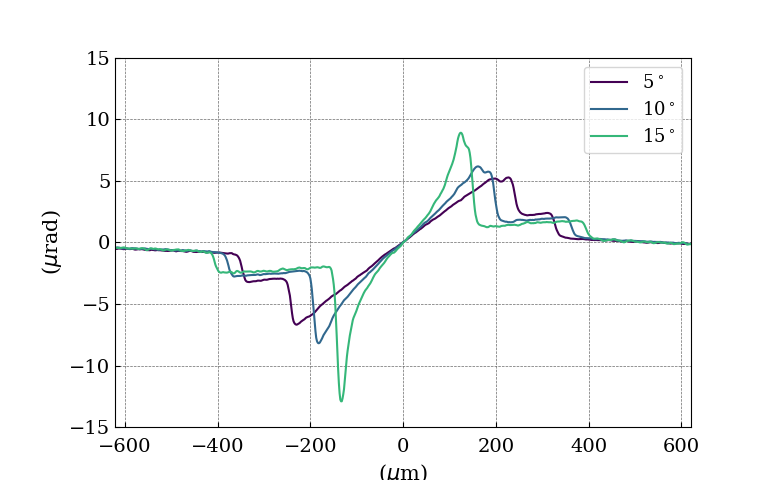

In [7]:
for i in range(len(scan)):
    image = b4pt.Image2Plot(hhbis[i, :]*1e6, x[i, :]*1e6)
    image.AspectRatio = False
    image.LaTex = True
    image.legends = ['', '($\mu$m)', '($\mu$rad)']
    image.LineStyle = '-'
    image.label = str(scan[i])+'$^\circ$'
    image.LabelPos = 1
    image.ax_limits = [-Av*1e6, Av*1e6, -15, 15]
    image.grid = True
    image.sort_class()
    image.ColorScheme =  colors[i]
    if i == 0:
        b4pt.plot_1D(image, Enable=False, Hold=False)
    elif i == len(scan)-1:
        b4pt.plot_1D(image, './results/1D_Be_R100um_ver_grad_exp_cuts_bis_orthogonal.png', Enable=True, Hold=True, dpi=dpi)
    else:
        b4pt.plot_1D(image, Enable=False, Hold=True)